# The local unitary cluster Jastrow (LUCJ) ansatz

This page explains the local unitary cluster Jastrow (LUCJ) ansatz, which was originally introduced in [this paper](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k). For a guide on simulating the LUCJ ansatz using ffsim, see [How to simulate the local unitary cluster Jastrow (LUCJ) ansatz](../how-to-guides/lucj.ipynb).

## The general unitary cluster Jastrow (UCJ) ansatz

The LUCJ ansatz is a specialized form of the general unitary cluster Jastrow (UCJ) ansatz, which has the form

$$
  \lvert \Psi \rangle = \prod_{k = 1}^L \mathcal{U}_k e^{i \mathcal{J}_k} \mathcal{U}_k^\dagger \lvert \Phi_0 \rangle
$$

where $\lvert \Phi_0 \rangle$ is a reference state, often taken as the Hartree-Fock state, each $\mathcal{U}_k$ is an [orbital rotation](orbital-rotation.ipynb), and each $\mathcal{J}_k$ is a diagonal Coulomb operator of the form

$$
    \mathcal{J} = \frac12\sum_{ij,\sigma \tau} \mathbf{J}^{\sigma \tau}_{ij} n_{i,\sigma} n_{j,\tau}.
$$

In ffsim, the UCJ ansatz is represented using classes that store the diagonal Coulomb matrices and orbital rotations as Numpy arrays. To facilitate variational optimization of the ansatzes, these classes implement methods for conversion to and from a vector of real-valued parameters. The parameter vector stores the entries of the UCJ matrices in a non-redundant way (for the orbital rotations, the parameter vector actually stores the entries of their logarithm).

### Spin-balanced and spin-unbalanced ansatzes

ffsim implements two variants of the UCJ ansatz, a "spin-balanced" ansatz, which is appropriate to apply to a closed-shell reference state, and a "spin-unbalanced" ansatz, which is appropriate to apply to an open-shell initial reference state.

In the spin-balanced ansatz, $\mathbf{J}^{\alpha\alpha} = \mathbf{J}^{\beta\beta}$ and $\mathbf{J}^{\alpha\beta} = \mathbf{J}^{\beta\alpha}$. As a result, each diagonal Coulomb operator is described by 2 matrices, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$, and both of these matrices are symmetric. The spin-balanced UCJ ansatz is represented by the [UCJOpSpinBalanced](../api/ffsim.rst#ffsim.UCJOpSpinBalanced) class.

In the spin-unbalanced ansatz, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\beta\beta}$ are allowed to differ, and $\mathbf{J}^{\alpha\beta}$ is no longer required to be symmetric. Since $\mathbf{J}^{\alpha\beta}_{ij} = \mathbf{J}^{\beta\alpha}_{ji}$, we don't need to store $\mathbf{J}^{\beta\alpha}$ separately. Therefore, each diagonal Coulomb operator is described by 3 matrices, $\mathbf{J}^{\alpha\alpha}$, $\mathbf{J}^{\alpha\beta}$, and $\mathbf{J}^{\beta\beta}$, and of these matrices, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\beta\beta}$ are symmetric. The spin-unbalanced UCJ ansatz is represented by the [UCJOpSpinUnbalanced](../api/ffsim.rst#ffsim.UCJOpSpinUnbalanced) class.

## The local UCJ (LUCJ) ansatz

Implementing the $e^{i \mathcal{J}_k}$ term of the UCJ ansatz requires either all-to-all connectivity or the use of a fermionic swap network, making it challenging for noisy pre-fault-tolerant quantum processors that have limited connectivity. The idea of the *local* UCJ ansatz is to impose sparsity constraints on the $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$ matrices which allow them to be implemented in constant depth on qubit topologies with limited connectivity. The constraints are specified by a list of indices indicating which matrix entries in the upper triangle are allowed to be nonzero (since the matrices are symmetric, only the upper triangle needs to be specified). These indices can be interpreted as pairs of orbitals that are allowed to interact.

As an example, consider a square lattice qubit topology. We can place the $\alpha$ and $\beta$ orbitals in parallel lines on the lattice, with connections between these lines forming "rungs" of a ladder shape, like this:

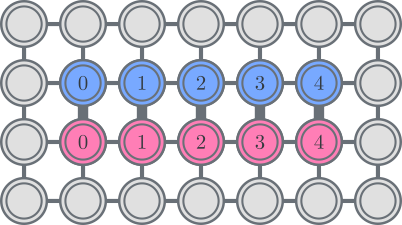

With this setup, orbitals with the same spin are connected with a line topology, while orbitals with different spins are connected when they share the same spatial orbital. This yields the following index constraints on the $\mathbf{J}$ matrices:

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, \ldots, N-1}
\end{align*}
$$

In other words, if the $\mathbf{J}$ matrices are nonzero only at the specified indices in the upper triangle, then the $e^{i \mathcal{J}_k}$ term can be implemented on a square topology without using any swap gates, in constant depth. Of course, imposing such constraints on the ansatz makes it less expressive, so more ansatz repetitions may be required.